# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and Combine HAR and EEG Datasets

In [2]:
har_fused_df = pd.read_csv('Scaled_Combined_Active_Gyro_Accel_Cleaned.csv')
har_fused_df = har_fused_df.rename(columns={'Activity_Label': 'Activity_Label_HAR'})

eeg_df = pd.read_csv('EEG_Features_Only_S1-6_Final.csv')

print(f"HAR Dataset shape (rows, columns): {har_fused_df.shape}")
print(f"EEG Dataset shape (rows, columns): {eeg_df.shape}")

combined_df = pd.concat([har_fused_df, eeg_df], axis=1)

print(f"Combined Dataset shape (rows, columns): {combined_df.shape}")

duplicates = combined_df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

print("\nActivity counts from 'Activity_Label_HAR':")
print(combined_df['Activity_Label_HAR'].value_counts())

print("\nActivity counts from 'Activity_Label_OpenBCI':")
print(combined_df['Activity_Label_OpenBCI'].value_counts())

print("\nFirst few rows of the combined dataset:")
print(combined_df.head())

combined_df.to_csv('Multimodal_EEG_HAR_Dataset.csv', index=False)
print("\nMultimodal dataset saved as 'Multimodal_EEG_HAR_Dataset.csv'!")

HAR Dataset shape (rows, columns): (230165, 9)
EEG Dataset shape (rows, columns): (24621, 113)
Combined Dataset shape (rows, columns): (230165, 122)
Number of duplicate rows: 0

Activity counts from 'Activity_Label_HAR':
Activity_Label_HAR
Marching in Place              36556
Wall Push-ups                  27090
Standing Heel-to-Toe Walk      26538
Seated Boxing Hooks            25783
Light Stationary Cycling       21696
Seated Medicine Ball Twists    18570
Seated Side Bends              18554
Chair Squats                   18509
Seated Leg Extensions          18498
Side-Stepping                  18371
Name: count, dtype: int64

Activity counts from 'Activity_Label_OpenBCI':
Activity_Label_OpenBCI
Wall Push-ups                  2877
Standing Heel-to-Toe Walk      2737
Seated Side Bends              2687
Seated Leg Extensions          2586
Marching in Place              2544
Seated Medicine Ball Twists    2544
Seated Boxing Hooks            2474
Chair Squats                   2285
Side-

# Process and Balance the Multimodal Dataset


Removed 0 duplicate rows.
Final shape after duplicate removal: (24621, 119)

Saved 'Multimodal_EEG_HAR_Balanced_Final_v2.2.csv'

Activity counts after duplicate removal:

Final_Activity_Label
Wall Push-ups                  2877
Standing Heel-to-Toe Walk      2737
Seated Side Bends              2687
Seated Leg Extensions          2586
Marching in Place              2544
Seated Medicine Ball Twists    2544
Seated Boxing Hooks            2474
Chair Squats                   2285
Side-Stepping                  1999
Light Stationary Cycling       1888
Name: count, dtype: int64


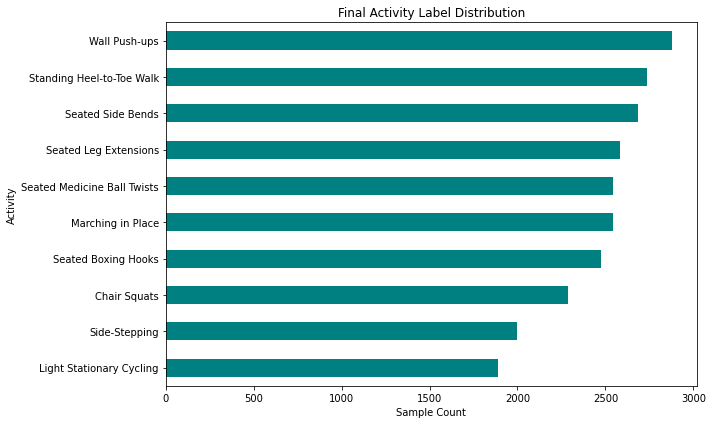

In [3]:
df = pd.read_csv("Multimodal_EEG_HAR_Dataset.csv", low_memory=False)
df.columns = df.columns.str.replace("Â°", "°").str.strip()

eeg_cols = [col for col in df.columns if "Ch" in col and any(band in col for band in ["Delta", "Theta", "Alpha", "Beta", "Gamma", "Std", "RMS"])]
har_cols = ["Accel X (g)", "Accel Y (g)", "Accel Z (g)", "Gyro X (°/s)", "Gyro Y (°/s)", "Gyro Z (°/s)"]
label_col = "Final_Activity_Label"

activity_list = sorted(set(df["Activity_Label_OpenBCI"].dropna()).union(set(df["Activity_Label_HAR"].dropna())))
combined_rows = []

for activity in activity_list:
    eeg_rows = df[df["Activity_Label_OpenBCI"] == activity].reset_index(drop=True)
    har_rows = df[df["Activity_Label_HAR"] == activity].reset_index(drop=True)
    
    min_count = min(len(eeg_rows), len(har_rows))
    
    if min_count == 0:
        max_count = max(len(eeg_rows), len(har_rows))
        print(f"Including partial data for: {activity} — using {max_count} rows")
        
        if len(eeg_rows) > 0:
            partial_df = pd.concat([
                eeg_rows[eeg_cols].reset_index(drop=True),
                pd.DataFrame([[float('nan')] * len(har_cols)] * len(eeg_rows), columns=har_cols),
                pd.Series([activity] * len(eeg_rows), name=label_col)
            ], axis=1)
            combined_rows.append(partial_df)
        
        elif len(har_rows) > 0:
            partial_df = pd.concat([
                pd.DataFrame([[float('nan')] * len(eeg_cols)] * len(har_rows), columns=eeg_cols),
                har_rows[har_cols].reset_index(drop=True),
                pd.Series([activity] * len(har_rows), name=label_col)
            ], axis=1)
            combined_rows.append(partial_df)
            
    else:
        eeg_sample = eeg_rows.sample(n=min_count, random_state=42).reset_index(drop=True)
        har_sample = har_rows.sample(n=min_count, random_state=42).reset_index(drop=True)
        
        merged = pd.concat([
            eeg_sample[eeg_cols],
            har_sample[har_cols],
            pd.Series([activity] * min_count, name=label_col)
        ], axis=1)
        combined_rows.append(merged)

final_df = pd.concat(combined_rows, ignore_index=True)
before_dedup = final_df.shape[0]
final_df = final_df.drop_duplicates()
after_dedup = final_df.shape[0]
print(f"\nRemoved {before_dedup - after_dedup} duplicate rows.")
print("Final shape after duplicate removal:", final_df.shape)

final_df.to_csv("Multimodal_EEG_HAR_Balanced_Final_v2.2.csv", index=False)
print("\nSaved 'Multimodal_EEG_HAR_Balanced_Final_v2.2.csv'")

print("\nActivity counts after duplicate removal:\n")
print(final_df[label_col].value_counts())

plt.figure(figsize=(10, 6))
final_df[label_col].value_counts().sort_values().plot(kind='barh', color='teal')
plt.title("Final Activity Label Distribution")
plt.xlabel("Sample Count")
plt.ylabel("Activity")
plt.tight_layout()
plt.show()

# Load and Inspect Final Dataset

In [4]:
file_path = 'Multimodal_EEG_HAR_Balanced_Final_v2.2.csv'
df = pd.read_csv(file_path)

print("Full dataset:")
print(df)

print("\nColumn names:")
print(df.columns.tolist())

Full dataset:
            Ch1_Std       Ch1_RMS     Ch1_Delta     Ch1_Theta     Ch1_Alpha  \
0      1.171362e+01  1.171455e+01  1.545709e+02  1.136476e+01  1.352785e+00   
1      2.585113e-04  2.726944e-04  1.143008e-08  2.023924e-10  3.756345e-12   
2      3.779291e+01  3.772484e+01  5.814354e+02  1.142740e+01  1.991369e+00   
3      1.324673e+02  1.332910e+02  3.896453e+03  4.593790e+02  3.632279e+01   
4      3.679947e-07  3.673028e-07  6.891314e-14  1.376034e-15  2.283754e-17   
...             ...           ...           ...           ...           ...   
24616  1.798222e-08  1.795093e-08  2.721746e-16  9.829382e-18  2.947257e-20   
24617  2.386863e-08  2.387259e-08  4.697621e-16  1.929357e-17  4.626635e-20   
24618  1.619312e-08  1.672359e-08  1.371260e-16  4.282930e-18  2.274289e-20   
24619  1.838436e-08  1.839180e-08  3.543114e-16  7.661932e-18  3.097910e-20   
24620  2.917502e+02  3.087488e+02  9.588811e+04  9.573027e+02  6.497476e+00   

           Ch1_Beta     Ch1_Gamma    